# Q6.Implement Convolutional Neural Networks (CNN) algorithm.

In [1]:
import pathlib
import numpy as np

In [2]:
pip install scikit-plot

In [3]:
import seaborn as sns
from matplotlib import pyplot
import scikitplot
from sklearn.metrics import classification_report

In [4]:
import cv2

In [5]:
import tensorflow as tf

In [6]:
print(tf.__version__)

2.8.0


In [7]:
from tensorflow import keras
from keras.callbacks import EarlyStopping

In [8]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [20]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [21]:
!pip install -q kaggle

In [22]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [23]:
!ls

dataset  kaggle.json  sample_data


In [24]:
!kaggle datasets download -d gauravsharma99/fer13-cleaned-dataset

 18% 5.00M/28.2M [00:01<00:05, 4.09MB/s]
100% 28.2M/28.2M [00:01<00:00, 21.6MB/s]


In [25]:
%mkdir -p dataset/

In [26]:
!unzip -q fer13-cleaned-dataset.zip -d dataset/

In [27]:
!pwd

/content


In [28]:
INPUT_PATH = "/content/dataset/"

In [29]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 2535 number of images
Happy has 6834 number of images
Neutral has 4295 number of images
disgust has 380 number of images
Angry has 2832 number of images

total images are 16876


In [30]:
TOP_EMOTIONS = ["fear", "Happy", "Neutral", "Angry"]
total_images -= 380
total_images

16496

In [31]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all Happy images to numpy arrays
loaded all Neutral images to numpy arrays
loaded all Angry images to numpy arrays


((16496, 48, 48, 3), array([0., 0., 0., ..., 3., 3., 3.]))

In [32]:
img_arr.shape, img_label.shape

((16496, 48, 48, 3), (16496,))

In [33]:
img_arr = img_arr/255

In [34]:
img_label = keras.utils.to_categorical(img_label)
img_label.shape

(16496, 4)

In [35]:
from sklearn.model_selection import train_test_split

training and testing splits

In [36]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.9, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14846, 48, 48, 3), (1650, 48, 48, 3), (14846, 4), (1650, 4))

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    train_size=0.85, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((12619, 48, 48, 3), (2227, 48, 48, 3), (12619, 4), (2227, 4))

In [38]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [39]:
num_classes

4

In [40]:
mobilenetV2 = keras.applications.mobilenet_v2.MobileNetV2(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobilenetV2.layers[-5].output
global_pool = keras.layers.GlobalMaxPool2D(name="global_pool")(x)
out = keras.layers.Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = keras.models.Model(inputs=mobilenetV2.input, outputs=out)

9420800/9406464 [==============================] - 0s 0us/step


In [41]:
for layer in model.layers[:15]:
    layer.trainable = False

In [42]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [43]:
filepath="/content/mobilenetV2-{epoch:02d}-{val_accuracy:.2f}.hdf5"

In [44]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [45]:
batch_size = 16
epochs = 160

optims = [
        keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
        keras.optimizers.Adam(),
]

model.compile(
        loss='categorical_crossentropy',
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    use_multiprocessing=True,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/160
788/788 [==============================] - 47s 41ms/step - loss: 1.4388 - accuracy: 0.4757 - val_loss: 1.0305 - val_accuracy: 0.6201
Epoch 2/160
788/788 [==============================] - 30s 38ms/step - loss: 0.9666 - accuracy: 0.6088 - val_loss: 0.9888 - val_accuracy: 0.6044
Epoch 3/160
788/788 [==============================] - 30s 37ms/step - loss: 0.9015 - accuracy: 0.6443 - val_loss: 0.9263 - val_accuracy: 0.6655
Epoch 4/160
788/788 [==============================] - 29s 37ms/step - loss: 0.8778 - accuracy: 0.6527 - val_loss: 1.0198 - val_accuracy: 0.6255
Epoch 5/160
788/788 [==============================] - 30s 37ms/step - loss: 0.8489 - accuracy: 0.6685 - val_loss: 1.5507 - val_accuracy: 0.5321
Epoch 6/160
788/788 [==============================] - 29s 37ms/step - loss: 0.8347 - accuracy: 0.6714 - val_loss: 1.0475 - val_accuracy: 0.6592
Epoch 7/160
788/788 [==============================] - 30s 37ms/step - loss: 0.8193 - accuracy: 0.6811 - val_loss: 1.1690 - val_ac

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

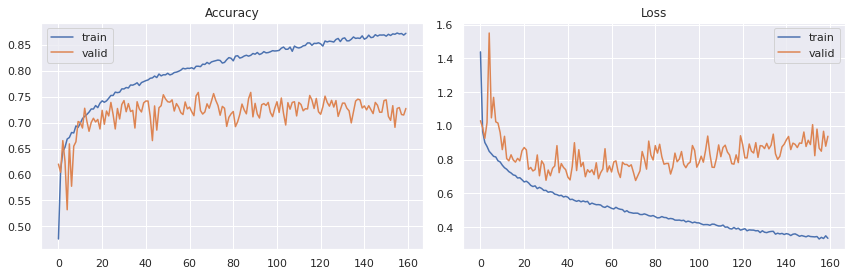

In [47]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [49]:
model.load_weights('/content/mobilenetV2-65-0.76.hdf5')  

test accuracy: 76.7879 %


              precision    recall  f1-score   support

           0       0.68      0.59      0.64       253
           1       0.90      0.87      0.88       684
           2       0.70      0.77      0.73       430
           3       0.65      0.67      0.66       283

    accuracy                           0.77      1650
   macro avg       0.73      0.73      0.73      1650
weighted avg       0.77      0.77      0.77      1650



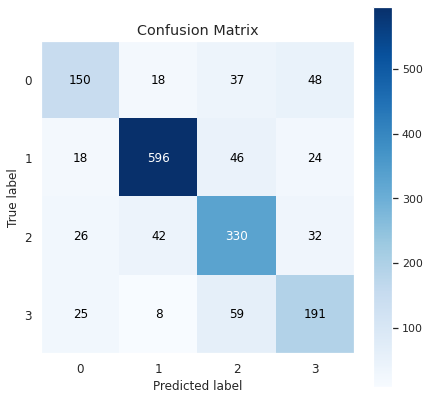

In [50]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [51]:
print('Test_loss',
np.mean(keras.metrics.categorical_crossentropy(
    y_test, model.predict(X_test)
)))

Test_loss 0.6781592


In [52]:
model.save("mobileNetV2_5_15.h5")

In [53]:
# from keras.preprocessing import image

# img = image.load_img("/content/dataset/Angry/Training_10017485.jpg",target_size = (48,48),color_mode = "grayscale")
# img = np.array(img)
# plt.imshow(img)
# print(img.shape) 

In [54]:
label_dict = {0:'Angry',1:'Neutral',2:'Fear',3:'Happy'}


(48, 48)


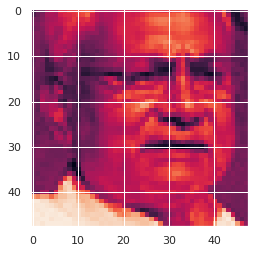

In [55]:
from keras.preprocessing import image
img = image.load_img('/content/dataset/Angry/Training_13485041.jpg',target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image


In [56]:
# img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
# img = img.reshape(1,48,48,1)
# print(img.shape) 
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (48, 48, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/content/dataset/Angry/Training_13485041.jpg')

result=model.predict(image)
result = list(result[0])
print(result)



[0.0062926547, 0.010955093, 0.015997611, 0.9667546]


In [57]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy
